## Setup
### Import libraries

In [27]:
#!pip install ipython-autotime
%load_ext autotime
import os
from tabulate import tabulate
import numpy as np
from google.cloud import aiplatform as aip
from google.cloud import bigquery
import pandas as pd

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.38 ms (started: 2022-11-26 21:57:41 -06:00)


### Set configurations and constants

In [28]:
NOTEBOOK ='Vertex_AI_Streamlit'
REGION = "us-central1"
PROJECT = 'babyweight-prediction'
BUCKET = 'b_w_bucket'
BQ_DATASET = "bw_dataset"
APPNAME = "bw-prediction"
GOOGLE_APPLICATION_CREDENTIALS = 'key/babyweight-prediction-ff79f406c099.json'

os.environ["REGION"] = REGION
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_APPLICATION_CREDENTIALS
GCS_BUCKET=f"gs://{BUCKET}"

time: 925 µs (started: 2022-11-26 21:57:42 -06:00)


---
## 1. Retrieve the Endpoint

In [29]:
aip.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=GCS_BUCKET)

time: 439 µs (started: 2022-11-26 21:57:42 -06:00)


In [30]:
ENDPOINT_NAME = 'projects/69318036822/locations/us-central1/endpoints/4074389870305345536'

time: 353 µs (started: 2022-11-26 21:57:42 -06:00)


In [31]:
endpoint = aip.Endpoint(
    project=PROJECT,
    location=REGION,
    endpoint_name=ENDPOINT_NAME
)

time: 14.7 ms (started: 2022-11-26 21:57:42 -06:00)


## 2. Make Online Predictions
### 2.1. One Sample

In [32]:
instance= [
    {'is_male': 'true',
     'mother_age': '45.0',
     'plurality': 'Single(1)',
     'gestation_weeks': '35.0',
     'cigarette_use': 'true',
     'alcohol_use': 'false',
     },
]

time: 477 µs (started: 2022-11-26 21:57:42 -06:00)


### Get Prediction

In [33]:
endpoint.predict(instance)

Prediction(predictions=[{'lower_bound': 2.85607647895813, 'upper_bound': 4.929884910583496, 'value': 6.105488300323486}], deployed_model_id='3368705715412664320', model_version_id='1', model_resource_name='projects/69318036822/locations/us-central1/models/697490594242494464', explanations=None)

time: 1.65 s (started: 2022-11-26 21:57:42 -06:00)


In [34]:
predicted_value = endpoint.predict(instance).predictions[0]['value']
predicted_value

6.105488300323486

time: 825 ms (started: 2022-11-26 21:57:43 -06:00)


## 3. Explaination
### 3.1.1

In [35]:
explain=endpoint.explain(instance)

time: 2.09 s (started: 2022-11-26 21:57:44 -06:00)


In [36]:
FEATURE_COLUMNS = [
    'is_male',
    'mother_age',
    'plurality',
    'gestation_weeks',
    'cigarette_use',
    'alcohol_use'
]

time: 410 µs (started: 2022-11-26 21:57:46 -06:00)


In [37]:
def get_feature_attributions(
        prediction_expl, instance_index, feature_columns=FEATURE_COLUMNS):
    """Returns the feature attributions with the baseline for a prediction example"""

    rows = []
    attribution = prediction_expl.explanations[instance_index].attributions[0]
    baseline_score = attribution.baseline_output_value
    total_att_val = baseline_score
    for key in feature_columns:
        feature_val = instance[instance_index][key]
        att_val = attribution.feature_attributions[key]
        total_att_val += att_val
        rows.append([key,feature_val,att_val])

    feature_attributions_rows = sorted(rows, key=lambda row: row[2], reverse=True)
    feature_attributions_rows.insert(0,["Baseline_Score", "--", baseline_score])
    feature_attributions_rows.append(["Final_Prediction", "--", total_att_val])

    return feature_attributions_rows

time: 1.13 ms (started: 2022-11-26 21:57:46 -06:00)


In [38]:
feature_attributions_rows = get_feature_attributions(explain, 0)

time: 674 µs (started: 2022-11-26 21:57:46 -06:00)


In [39]:
def generate_dataframe():
    feature_list=[]
    feature_values=[]
    feature_contributions=[]
    feature_attributions_rows = get_feature_attributions(explain, 0)

    for i in range(len(feature_attributions_rows)):
        feature=feature_attributions_rows[i][0]
        feature_list.append(feature)

    for i in range(len(feature_attributions_rows)):
        feature=feature_attributions_rows[i][1]
        feature_values.append(feature)

    for i in range(len(feature_attributions_rows)):
        feature=feature_attributions_rows[i][2]
        feature_contributions.append(feature)

    zipped = list(zip(feature_list, feature_values, feature_contributions))
    df = pd.DataFrame(zipped, columns=['Feature', 'Value', 'Contribution'])

    return df, feature_list, feature_values,feature_contributions


time: 1.03 ms (started: 2022-11-26 21:57:46 -06:00)


In [40]:
df, feature_list, feature_values,feature_contributions=generate_dataframe()

time: 1.31 ms (started: 2022-11-26 21:57:46 -06:00)


In [41]:
df

,Feature,Value,Contribution
0,Baseline_Score,--,7.805862
1,is_male,true,0.000000
2,plurality,Single(1),0.000000
3,alcohol_use,false,0.000000
4,mother_age,45.0,-0.029131
5,cigarette_use,true,-0.236360
6,gestation_weeks,35.0,-1.434883
7,Final_Prediction,--,6.105488


time: 6.04 ms (started: 2022-11-26 21:57:46 -06:00)


time: 11.7 ms (started: 2022-11-26 21:57:46 -06:00)


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

time: 582 ms (started: 2022-11-26 21:57:46 -06:00)


<AxesSubplot: xlabel='Contribution', ylabel='Feature'>

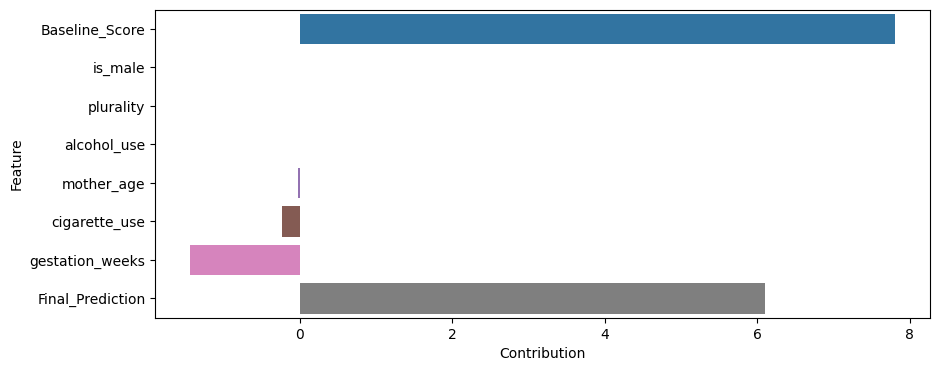

time: 254 ms (started: 2022-11-26 21:57:47 -06:00)


In [43]:
fig = plt.figure(figsize=(10, 4))
sns.barplot(x = "Contribution", y = "Feature", data = df)
#st.pyplot(fig)

In [44]:
df

,Feature,Value,Contribution
0,Baseline_Score,--,7.805862
1,is_male,true,0.000000
2,plurality,Single(1),0.000000
3,alcohol_use,false,0.000000
4,mother_age,45.0,-0.029131
5,cigarette_use,true,-0.236360
6,gestation_weeks,35.0,-1.434883
7,Final_Prediction,--,6.105488


time: 5.9 ms (started: 2022-11-26 21:57:47 -06:00)


In [45]:
df2=df.query("Feature in ('Baseline_Score','Final_Prediction')")
df2

,Feature,Value,Contribution
0,Baseline_Score,--,7.805862
7,Final_Prediction,--,6.105488


time: 9.05 ms (started: 2022-11-26 21:57:47 -06:00)


In [46]:
df

,Feature,Value,Contribution
0,Baseline_Score,--,7.805862
1,is_male,true,0.000000
2,plurality,Single(1),0.000000
3,alcohol_use,false,0.000000
4,mother_age,45.0,-0.029131
5,cigarette_use,true,-0.236360
6,gestation_weeks,35.0,-1.434883
7,Final_Prediction,--,6.105488


time: 6.22 ms (started: 2022-11-26 21:58:14 -06:00)


In [49]:
df['Contribution'][1]

0.0

time: 2.86 ms (started: 2022-11-26 21:59:23 -06:00)


In [50]:
df.loc['is_male', 'Contribution']

KeyError: 'is_male'

time: 2.13 s (started: 2022-11-26 22:28:54 -06:00)


In [51]:
df3=df.copy()

time: 528 µs (started: 2022-11-26 22:31:13 -06:00)


In [52]:
df3

,Feature,Value,Contribution
0,Baseline_Score,--,7.805862
1,is_male,true,0.000000
2,plurality,Single(1),0.000000
3,alcohol_use,false,0.000000
4,mother_age,45.0,-0.029131
5,cigarette_use,true,-0.236360
6,gestation_weeks,35.0,-1.434883
7,Final_Prediction,--,6.105488


time: 5.4 ms (started: 2022-11-26 22:31:15 -06:00)


In [56]:
df3=df3.set_index('Feature')
df3

,Value,Contribution
Feature,,
Baseline_Score,--,7.805862
is_male,true,0.000000
plurality,Single(1),0.000000
alcohol_use,false,0.000000
mother_age,45.0,-0.029131
cigarette_use,true,-0.236360
gestation_weeks,35.0,-1.434883
Final_Prediction,--,6.105488


time: 9.66 ms (started: 2022-11-26 22:35:17 -06:00)


In [58]:
df3.loc['mother_age', 'Contribution']

-0.0291309654712677

time: 3.05 ms (started: 2022-11-26 22:35:44 -06:00)
